In [1]:
import sys # for automation and parallelisation
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])
if manual:
    %matplotlib inline

In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none func

In [2]:
import numpy as np
import pandas as pd
from quetzal.model import stepmodel
import matplotlib.pyplot as plt

# Logit model step
## Needs LoS tables and calibration parameters
## Saves logit probabilities and utilities

In [3]:
input_path = '../input/'
output_path = '../output/'
model_path = '../model/' + scenario + '/'

In [4]:
sm = stepmodel.read_json(model_path + 'de_pt_los')
car = stepmodel.read_json(model_path + 'de_road_los')

In [5]:
# Scale time to hours
if sm.pt_los['time'].mean() > 3600:
    sm.pt_los['time'] = sm.pt_los['time'] / 3600
elif sm.pt_los['time'].mean() < 10/3600:
    sm.pt_los['time'] = sm.pt_los['time'] * 3600
sm.pt_los['time'].mean()

5.650460207815043

In [6]:
if car.car_los['time'].mean() > 3600:
    car.car_los['time'] = car.car_los['time'] / 3600
car.car_los['time'].mean()

4.371867598400412

In [7]:
# Define route types for the choice tree
route_types = ['rail',#'rail_long', 'rail_short',
               'bus',#'coach', 'bus',
               'air','car', 'walk']

In [8]:
# Aggregate route types rail and road PT
type_dict = {'rail_long': 'rail', 'rail_short': 'rail', 'rail': 'rail',
             'coach': 'bus', 'bus': 'bus',
             'air': 'air', 'car': 'car', 'walk': 'walk'}
assert set(route_types).issubset(set(type_dict.keys()))
if 'rail_short' in sm.pt_los['route_type']:
    sm.pt_los['route_type_disagg'] = sm.pt_los['route_type'].copy()
sm.pt_los['route_type'] = sm.pt_los['route_type'].map(type_dict)

In [9]:
sm.pt_los.sample()

,access_time,accessibility,destination,footpath_time,in_vehicle_time,length,link_path,mode_utility,ntransfers,origin,...,"(""('Fz1', 0)"", 'probability')","(""('Fz1', 1)"", 'probability')","(""('Fz2', 0)"", 'probability')","(""('Fz2', 1)"", 'probability')","(""('Fz3', 0)"", 'probability')","(""('Fz3', 1)"", 'probability')","(""('Fz4', 0)"", 'probability')","(""('Fz4', 1)"", 'probability')","(""('Fz6', 0)"", 'probability')","(""('Fz6', 1)"", 'probability')"
index,,,,,,,,,,,,,,,,,,,,,
432232,1501,NaN,DE133,72,20100,467477,"[bus_739262, rs_54658, rs_54659, rs_54660, rs_...",-2.670818,4,DEA1E,...,0.192179,0.03202,0.261556,0.173194,0.203741,0.025133,0.156521,0.026229,0.196405,0.04037


In [10]:
# Create LoS table
sm.los = pd.concat([sm.pt_los, car.car_los])
sm.los.reset_index(drop=True, inplace=True)
len(sm.los)

845564

In [11]:
sm.los.drop([col for col in sm.los.columns if col.startswith('(')],
            axis=1, inplace=True, errors='ignore')

In [12]:
# Clean LoS table
sm.los = sm.los.loc[sm.los['time']>0]
sm.los = sm.los.loc[sm.los['length']<=1000000]
len(sm.los)

845564

In [13]:
# Make route types hashable
sm.los['route_types'] = sm.los['route_types'].apply(tuple)

## Prepare the logit model

Load parameters and generate LoS columns

In [14]:
# Transport demand segments: the cartesian product of
# trip purposes and car ownership
segments_tuple = [('Fz'+str(p), car) for p in [1,2,3,4,6] for car in [0,1]]
# Convert tuple segments to strings in order to prevent issues
segments = [str(seg) for seg in segments_tuple]

In [15]:
# Create a column for generalised cost, see cal20
vot = pd.read_csv(input_path + 'vot.csv', header=[0,1], index_col=0).to_dict()
m_dict = {'rail_long': 'PT', 'rail_short': 'PT', 'rail': 'PT',
          'coach': 'PT', 'bus': 'PT', 'air': 'air', 'car': 'car'}
'''# Take averages over distances
vot = {('Fz1', 'PT'): 4.47, ('Fz1', 'air'): 33.67, ('Fz1', 'car'): 4.87,
       ('Fz2', 'PT'): 4.39, ('Fz2', 'air'): 33.67, ('Fz2', 'car'): 3.9,
       ('Fz3', 'PT'): 5.11, ('Fz3', 'air'): 33.67, ('Fz3', 'car'): 4.29,
       ('Fz4', 'PT'): 7.01, ('Fz4', 'air'): 38.76, ('Fz4', 'car'): 8.5,
       ('Fz6', 'PT'): 4.35, ('Fz6', 'air'): 25.45, ('Fz6', 'car'): 4.35}'''
'''# Take the same VoT for every segment
sm.los['gc'] = sm.los['time'] + [c / vot['root', m_dict[m]][int(d/1000)]
    if m!='walk' else 0 for c,d,m in zip(sm.los['price'], sm.los['length'], sm.los['route_type'])]
'''
# Take segment-specific VoT
for s in segments_tuple:
    sm.los[(str(s), 'gc')] = sm.los['time'] + [c / vot[s[0], 'all'][int(d/1000)] # m_dict[m] for mode-specific instead of all
        if m!='walk' else 0 for c,d,m in zip(
            sm.los['price'], sm.los['length'], sm.los['route_type'])]

In [16]:
# Load estimation results
excel = pd.ExcelFile(input_path + 'estimation_results_car_own.xls')
params_est = []
for segment in range(2, len(segments)+2): # First two sheets are all purposes
    df = excel.parse(segment)
    params_est.append(df.set_index(df.columns[0]))

In [17]:
# The nested logit structure can be set for each segment
# It must be the same as in the estimation
segs = segments + ['root']
col = ['root']*len(route_types) + [np.nan] #['pt']*(len(route_types)-3) + ['root']*4 + [np.nan]
nests = pd.DataFrame(index=route_types+['root'], #['pt', 'root'],
                     data={s: col for s in segments})
nests.index.name = 'route_type'
nests.columns.name = 'segment'
sm.mode_nests = nests
sm.mode_nests

segment,"('Fz1', 0)","('Fz1', 1)","('Fz2', 0)","('Fz2', 1)","('Fz3', 0)","('Fz3', 1)","('Fz4', 0)","('Fz4', 1)","('Fz6', 0)","('Fz6', 1)"
route_type,,,,,,,,,,
rail,root,root,root,root,root,root,root,root,root,root
bus,root,root,root,root,root,root,root,root,root,root
air,root,root,root,root,root,root,root,root,root,root
car,root,root,root,root,root,root,root,root,root,root
walk,root,root,root,root,root,root,root,root,root,root
root,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
# phi/theta values for each mode and nest come from calibration data
sm.logit_scales = pd.DataFrame(index=route_types, data={seg: 1 for seg in segments})
sm.logit_scales.loc['root'] = [1 for _ in range(len(segments))]
# For the nested structure
#sm.logit_scales.loc['pt'] = [1 / params_est[i].loc['mu_pt', 'Value']
#                             for i in range(len(segments))]
sm.logit_scales

,"('Fz1', 0)","('Fz1', 1)","('Fz2', 0)","('Fz2', 1)","('Fz3', 0)","('Fz3', 1)","('Fz4', 0)","('Fz4', 1)","('Fz6', 0)","('Fz6', 1)"
rail,1,1,1,1,1,1,1,1,1,1
bus,1,1,1,1,1,1,1,1,1,1
air,1,1,1,1,1,1,1,1,1,1
car,1,1,1,1,1,1,1,1,1,1
walk,1,1,1,1,1,1,1,1,1,1
root,1,1,1,1,1,1,1,1,1,1


In [19]:
# Initial values are the alternative specific constants (ASC) from calibration
sm.mode_utility = pd.DataFrame({seg: [] for seg in segments})
for t, asc in [('rail', 'asc_rail'),
#               ('rail_short', 'asc_rail_s'),
#               ('rail_long', 'asc_rail_l'),
#               ('coach', 'asc_coach'),
               ('bus', 'asc_road'),
               ('air', 'asc_air'), ('car', 0),
               ('walk', 'asc_non_motor'),('root', 0)]:
    sm.mode_utility.loc[t] = [params_est[i].loc[asc, 'Value']
                              if isinstance(asc, str) else asc
                              for i in range(len(segments))]
sm.mode_utility

,"('Fz1', 0)","('Fz1', 1)","('Fz2', 0)","('Fz2', 1)","('Fz3', 0)","('Fz3', 1)","('Fz4', 0)","('Fz4', 1)","('Fz6', 0)","('Fz6', 1)"
rail,3.750434,-1.865671,3.366965,-0.419847,3.052243,-2.978782,1.692048,-2.487871,3.827032,-2.720135
bus,2.547755,-3.395499,3.095130,-0.566808,2.378163,-3.743464,-0.107990,-3.925487,2.628686,-3.598994
air,-5.535597,-8.271691,-6.254427,-9.361773,-6.735345,-6.199273,-0.930260,-2.841741,-6.548516,-3.966244
car,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
walk,0.049253,-5.382476,0.541252,-3.146874,1.182597,-4.625793,-1.598662,-4.906671,1.193882,-4.190567
root,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [20]:
# Performance attributes for mode choice
#perf_attrs = ['gc_d']#, 'accessibility']
perf_attrs = [str((s, 'gc_d')) for s in segments]

In [21]:
# Beta parameters from calibration data
# IMPORTANT: watch the conversion
sm.utility_values = pd.DataFrame({seg: [0]*len(perf_attrs)
                                  for seg in segments}, index=perf_attrs)
sm.utility_values.loc['mode_utility'] = [1 for seg in segments]
for a,s in zip(perf_attrs, segments):
    sm.utility_values.loc[a, s] = params_est[segments.index(s)].loc['b_gc', 'Value']
sm.utility_values

,"('Fz1', 0)","('Fz1', 1)","('Fz2', 0)","('Fz2', 1)","('Fz3', 0)","('Fz3', 1)","('Fz4', 0)","('Fz4', 1)","('Fz6', 0)","('Fz6', 1)"
"(""('Fz1', 0)"", 'gc_d')",-0.049379,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"(""('Fz1', 1)"", 'gc_d')",0.000000,-0.489746,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"(""('Fz2', 0)"", 'gc_d')",0.000000,0.000000,-0.705112,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"(""('Fz2', 1)"", 'gc_d')",0.000000,0.000000,0.000000,-0.282794,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"(""('Fz3', 0)"", 'gc_d')",0.000000,0.000000,0.000000,0.000000,-0.148246,0.000000,0.000000,0.000000,0.000000,0.000000
"(""('Fz3', 1)"", 'gc_d')",0.000000,0.000000,0.000000,0.000000,0.000000,-0.339644,0.000000,0.000000,0.000000,0.000000
"(""('Fz4', 0)"", 'gc_d')",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.075258,0.000000,0.000000,0.000000
"(""('Fz4', 1)"", 'gc_d')",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.214706,0.000000,0.000000
"(""('Fz6', 0)"", 'gc_d')",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.121983,0.000000
"(""('Fz6', 1)"", 'gc_d')",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.117674


In [22]:
# Generate damped cost
def spline(x, beta=1, Q=3, c0=0, c1=20, c2=40, c3=np.inf):
    c = [c0,c1,c2,c3]
    alpha = [0, -beta/2*np.power(np.log(c1),3),
             -beta/2*np.log(c1)*(3*np.power(np.log(c2),2)+np.power(np.log(c1),2))] # for Q=3
    theta = [1, 3/2*np.log(c1), 3*np.log(c1)*np.log(c2)] # for Q=3
    def component(x, q):
        return beta*theta[q-1]*np.power(np.log(x),Q-q+1) + alpha[q-1]
    return sum([component(x, q) if x>=c[q-1] and x<c[q] else 0 for q in range(1,Q+1)])
for a, s in zip(perf_attrs, segments):
    sm.los[a] = sm.los[(s, 'gc')].apply(spline)
#sm.los['gc_d'] = sm.los['gc'].apply(spline)

In [23]:
# Show the performance attributes
sm.los.sample(5).sort_values('length').set_index(
    ['origin', 'destination', 'route_type'])[perf_attrs+['length']]

,,,"(""('Fz1', 0)"", 'gc_d')","(""('Fz1', 1)"", 'gc_d')","(""('Fz2', 0)"", 'gc_d')","(""('Fz2', 1)"", 'gc_d')","(""('Fz3', 0)"", 'gc_d')","(""('Fz3', 1)"", 'gc_d')","(""('Fz4', 0)"", 'gc_d')","(""('Fz4', 1)"", 'gc_d')","(""('Fz6', 0)"", 'gc_d')","(""('Fz6', 1)"", 'gc_d')",length
origin,destination,route_type,,,,,,,,,,,
DEA15,DEA54,car,1.141746,1.141746,1.656545,1.656545,1.222664,1.222664,0.994055,0.994055,1.408007,1.408007,141421
DEE0D,DEG04,car,5.054025,5.054025,6.623028,6.623028,5.701889,5.701889,4.699341,4.699341,5.615982,5.615982,300986
DE40A,DE737,bus,6.781572,6.781572,9.070627,9.070627,7.945463,7.945463,6.228419,6.228419,7.442160,7.442160,499721
DEF0B,DE11B,air,28.717624,28.717624,42.575712,42.575712,37.003407,37.003407,24.578121,24.578121,32.592401,32.592401,644396
DE21C,DEA12,air,22.110019,22.110019,37.078970,37.078970,31.766636,31.766636,18.172584,18.172584,25.556566,25.556566,865466


## Mode Choice

In [24]:
# Build the utility column in sm.los for each segment
sm.segments = segments
# How defines the mode which ASC is taken: "min" is worst mode in route_types,
# "max" is best, "sum" and "mean"
# Set the main mode as route types to take only this ASC
#sm.los['route_types'] = [(i,) for i in sm.los['route_type']]
sm.analysis_mode_utility(how='main', segment=None)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.31it/s]


In [25]:
# Run the logit model to calculate probabilities
sm.step_logit()

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:50<00:00,  5.09s/it]


In [26]:
print(sm.probabilities.shape)
print(sm.utilities.shape)

(1603950, 9)
(1603950, 9)


In [27]:
sm.probabilities.sample(n=3)

route_type,origin,destination,segment,root,walk,car,air,bus,rail
153110,DEG0I,DE25A,"('Fz1', 0)",1,0.0,0.006307,0.0,0.071414,0.922278
105474,DEB3C,DE407,"('Fz3', 0)",1,0.0,0.020882,0.0,0.000000,0.979118
87888,DEA14,DEG0D,"('Fz6', 0)",1,0.0,0.008398,0.0,0.000000,0.991602


In [28]:
sm.utilities.sample(n=3)

route_type,origin,destination,segment,root,walk,car,air,bus,rail
15083,DE216,DEB25,"('Fz2', 1)",-3.141457,-inf,-3.678270,-inf,-inf,-4.019991
68793,DE723,DE231,"('Fz2', 1)",-1.702365,-inf,-2.011582,-inf,-inf,-3.026705
87918,DE929,DEG0G,"('Fz6', 0)",4.662021,-inf,-0.526181,-inf,2.013855,4.582585


In [29]:
sm.los.sample()

,access_time,accessibility,destination,footpath_time,in_vehicle_time,length,link_path,mode_utility,ntransfers,origin,...,"(('Fz1', 0), probability)","(('Fz1', 1), probability)","(('Fz2', 0), probability)","(('Fz2', 1), probability)","(('Fz3', 0), probability)","(('Fz3', 1), probability)","(('Fz4', 0), probability)","(('Fz4', 1), probability)","(('Fz6', 0), probability)","(('Fz6', 1), probability)"
313237,1202,NaN,DE406,59,9228,235677,"[rl_2864, rl_2865, rl_2866, rl_2867, rl_2868, ...",-2.720135,1,DE803,...,0.339447,0.067089,0.459406,0.181598,0.355412,0.027193,0.323924,0.055828,0.354474,0.046168


## Save model

In [31]:
sm.utilities.reset_index(drop=True, inplace=True)
sm.probabilities.reset_index(drop=True, inplace=True)
sm.to_json(model_path + 'de_logit', only_attributes=[
    'segments', 'mode_nests', 'logit_scales', 'mode_utility',
    'utility_values', 'probabilities', 'utilities'],
           encoding='utf-8')

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 38/38 [00:20<00:00,  1.85it/s]


In [32]:
# Save LoS table
sm.pt_los = sm.los.loc[sm.los['route_type']!='car']
sm.to_json(model_path + 'de_pt_los', only_attributes=['pt_los'],
           encoding='utf-8')
sm.car_los = sm.los.loc[sm.los['route_type']=='car']
sm.to_json(model_path + 'de_road_los', only_attributes=['car_los'],
           encoding='utf-8')

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 39/39 [00:25<00:00,  1.52it/s]


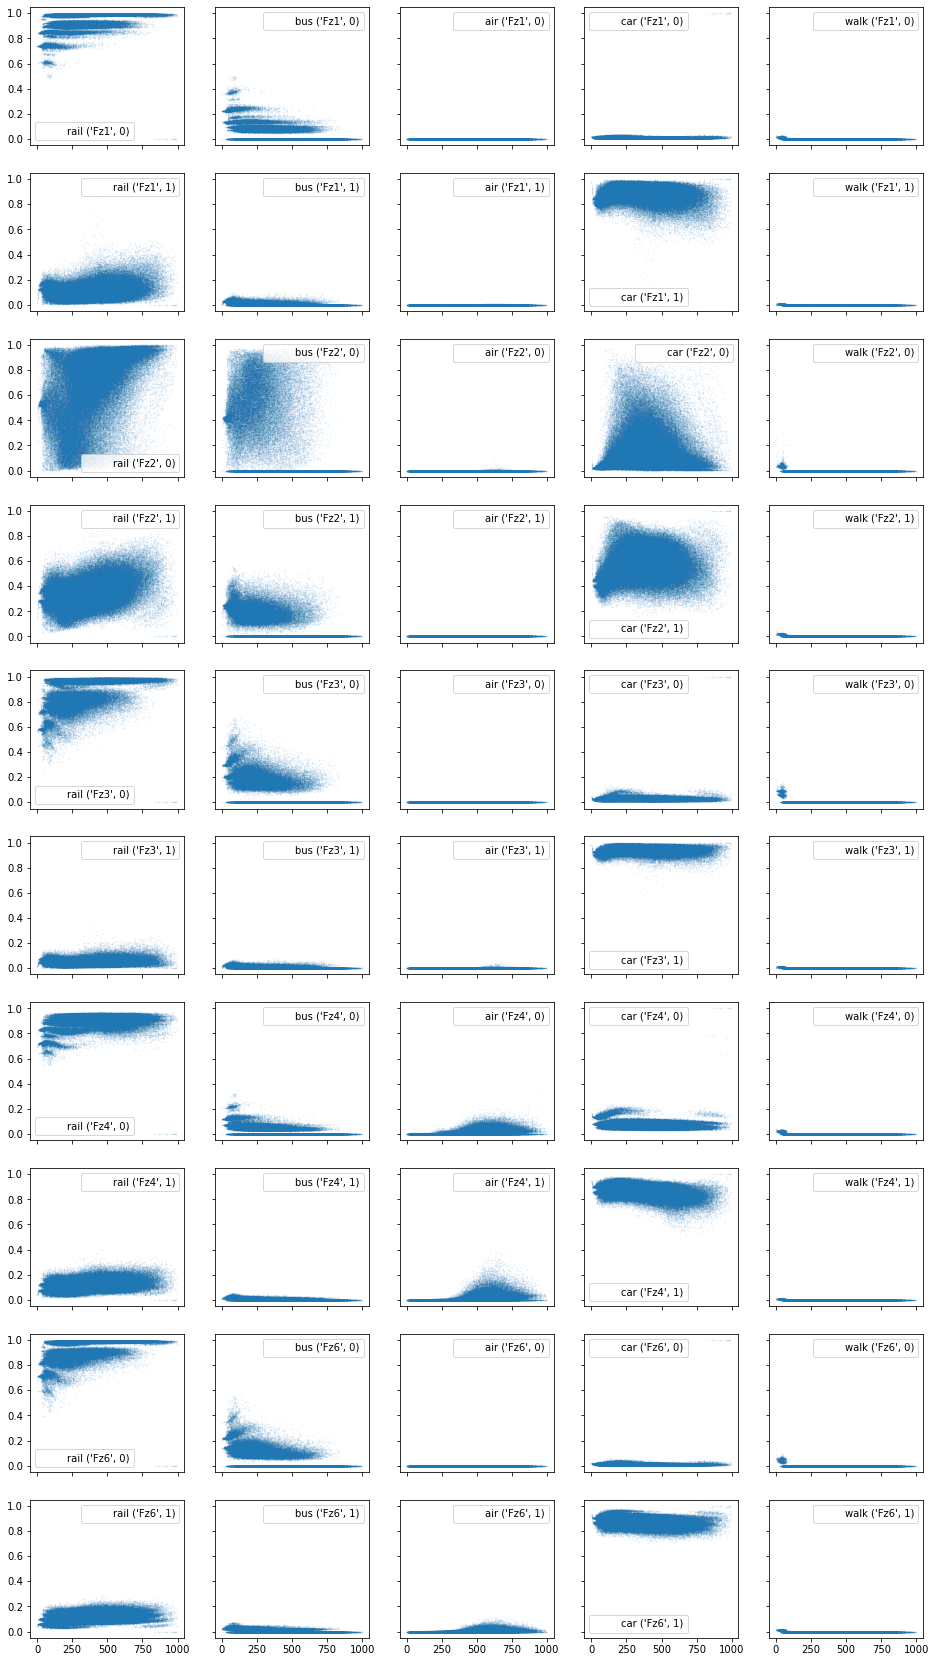

In [30]:
# Distance-distribution of probabilities
if manual:
    merged = sm.probabilities.merge(car.car_los[['origin', 'destination', 'length']],
                                    on=['origin', 'destination'], how='inner')
    fig, ax = plt.subplots(nrows=len(segments), ncols=len(route_types),
                           sharex='all', sharey='all', figsize=(16,len(segments)*3))
    for j, mode in zip(range(len(route_types)), route_types):
        for i, seg in zip(range(len(segments)), segments):
            x = merged.loc[merged['segment']==seg, 'length'] / 1000
            y = merged.loc[merged['segment']==seg, mode]
            ax[i,j].scatter(x, y, marker='o', s=.15, alpha=.1, label=mode+' '+seg)
            #p = np.poly1d(np.polyfit(x, y, deg=3))
            #ax[i,j].plot(x, p(x), linestyle='', marker='o', markersize=.5, color='grey', label=mode+' '+seg)
            ax[i,j].legend()